# CycleGAN (Horse2Zebra)

- https://junyanz.github.io/CycleGAN （PJのページ、いろいろなアプリケーションがある）
- https://github.com/junyanz/CycleGAN （論文で言及されているTorch版のコード）
- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix （同じ著者がPyTorchで再実装したコード）
- Figure1
    - CycleGANで実現できることのイメージ
    - 今回はHorse <=> Zebraの実験
- Figure2
    - ペアのデータセットを使ってある画像を別の画像に変換する（pix2pix）
    - 通常はペアのデータセットというのは手に入らない
    - ペアにはなっていない画像集合（ドメインA）から画像集合（ドメインB）への変換（またはその逆）を学習するのが目的

- 学習ログを記録するためにTensorboardXを使う
- `pip install tensorboardX`

In [4]:
import os
import random
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

%matplotlib inline

# Hyperparameters

- バッチサイズは1が普通か？
- 大きくするとうまくいかないという報告がある

In [21]:
# hyperparameters
load_size = 286  # オリジナルの画像はこのサイズにリサイズ
fine_size = 256  # 286x286の画像からランダムに256x256をcrop
batch_size = 1
num_epoch = 200

lr = 0.0002  # initial learning rate for adam
beta1 = 0.5  # momentum term of adam

save_epoch_freq = 5
log_dir = 'logs'

cuda = torch.cuda.is_available()
if cuda:
    print('cuda available!')

## DataLoader

- 自作データセットを作るためには `Dataset` を継承
- `__getitem__(index)` を実装して [] 演算子で個別データにアクセスできるようにする
- データは辞書形式で返す
- 入力画像は [-1, 1] の範囲に正規化

In [23]:
class UnalignedDataset(torch.utils.data.Dataset):

    def __init__(self, is_train):
        super(torch.utils.data.Dataset, self).__init__()

        root_dir = os.path.join('data', 'horse2zebra')
        
        if is_train:
            dir_A = os.path.join(root_dir, 'trainA')
            dir_B = os.path.join(root_dir, 'trainB')
        else:
            dir_A = os.path.join(root_dir, 'testA')
            dir_B = os.path.join(root_dir, 'testB')

        self.image_paths_A = self._make_dataset(dir_A)
        self.image_paths_B = self._make_dataset(dir_B)

        self.size_A = len(self.image_paths_A)
        self.size_B = len(self.image_paths_B)

        self.transform = self._make_transform(is_train)

    def __getitem__(self, index):
        index_A = index % self.size_A
        path_A = self.image_paths_A[index_A]
        
        # クラスBの画像はランダムに選択
        index_B = random.randint(0, self.size_B - 1)
        path_B = self.image_paths_B[index_B]

        img_A = Image.open(path_A).convert('RGB')
        img_B = Image.open(path_B).convert('RGB')
        
        # データ拡張
        A = self.transform(img_A)
        B = self.transform(img_B)
        
        return {'A': A, 'B': B, 'path_A': path_A, 'path_B': path_B}
    
    def __len__(self):
        return max(self.size_A, self.size_B)

    def _make_dataset(self, dir):
        images = []
        for fname in os.listdir(dir):
            if fname.endswith('.jpg'):
                path = os.path.join(dir, fname)
                images.append(path)
        sorted(images)
        return images

    def _make_transform(self, is_train):
        transforms_list = []
        transforms_list.append(transforms.Resize((load_size, load_size), Image.BICUBIC))
        transforms_list.append(transforms.RandomCrop(fine_size))
        if is_train:
            transforms_list.append(transforms.RandomHorizontalFlip())
        transforms_list.append(transforms.ToTensor())
        transforms_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))  # [0, 1] => [-1, 1]
        return transforms.Compose(transforms_list)

In [29]:
train_dataset = UnalignedDataset(is_train=True)
train_dataset
#
# train_loader = torch.utils.data.DataLoader(train_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=True,
#                                            num_workers=0)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'data\\horse2zebra\\trainA'

- バッチサイズは1
- batch['A'] にはドメインAの画像、batch['path_A'] にはそのファイルのパス
- batch['B'] にはドメインBの画像、batch['path_B'] にはそのファイルのパス

In [8]:
# SAMPLE TEST
batch = iter(train_loader).next()
print(batch['A'].shape)
print(batch['B'].shape)
print(batch['path_A'])
print(batch['path_B'])

NameError: name 'train_loader' is not defined

In [ ]:
# データの描画
def imshow(img):
    npimg = img.numpy()
    npimg = 0.5 * (npimg + 1)  # [-1,1] => [0, 1]
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
batch = iter(train_loader).next()
images_A = batch['A']  # horses
images_B = batch['B']  # zebras

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
imshow(make_grid(images_A, nrow=4))
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(make_grid(images_B, nrow=4))
plt.axis('off')

## Model

- Generatorは9ブロックのResNet
- BatchNormalizationではなく、InstanceNormalizationを使う
- DCGANなどではノイズから画像を生成していたが、CycleGANでは別ドメインの画像から画像を生成する
- 入力が1次元ノイズではなくて2次元のカラー画像になっている

In [9]:
class ResNetBlock(nn.Module):

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True),
                       nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3),
                       nn.InstanceNorm2d(dim)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [10]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),

            nn.Conv2d(3, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),

            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )

        # initialize weights
        self.model.apply(self._init_weights)

    def forward(self, input):
        return self.model(input)

    def _init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal(m.weight.data, 0.0, 0.02)

- Discriminatorは普通のCNN
- DCGANのように0 or 1をスカラーで返さないで30x30のfeature mapを出力する

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

        # initialize weights
        self.model.apply(self._init_weights)

    def forward(self, input):
        return self.model(input)

    def _init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal(m.weight.data, 0.0, 0.02)

In [12]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

gen = Generator()
print_network(gen)

disc = Discriminator()
print_network(disc)

C:\Users\sangh\AppData\Local\Temp/ipykernel_4876/739604368.py:53: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight.data, 0.0, 0.02)


Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5)

C:\Users\sangh\AppData\Local\Temp/ipykernel_4876/1391524384.py:30: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight.data, 0.0, 0.02)


## Loss function

- 3つのlossを導入する
- Adversarial Loss
    - まず画像の生成問題であるためGeneratorが生成した画像をDiscriminatorが見破れるかというこれまでのGANと同じLoss
    - X->YとY->Xのそれぞれについて
- Cycle consistency loss
    - X->Yの画像を生成して、Y->Xの画像を生成したときに元のXに近くなるか？
    - GANのためYはドメインYの画像っぽく（シマウマっぽく）なってる必要ある
    - YからXに戻したときにドメインXの元の画像っぽく（馬っぽく）なってる必要がある
    - より強い制約を与えるためにcycle consistency lossを導入する
- Identity loss
    - 変換先の画像を入れてもそのまま何もしないという制約

- Adversarial Lossの定義
- Generatorは偽物を本物（target_is_real = True）としてほしいし
- Discriminatorは偽物を偽物（target_is_real = False）としてほしい
- Discriminatorは30x30のfeature mapを返す実装になっている
- 本物ラベル（全部1）や偽物ラベル（全部0）のターゲットベクトルを効率的に求められるようにクラス化している

In [13]:
class ImagePool():

    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        # プールを使わないときはそのまま返す
        if self.pool_size == 0:
            return Variable(images)
        return_images = []
        for image in images:
            # バッチの次元を削除して3Dテンソルに
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [14]:
class GANLoss(nn.Module):
    
    def __init__(self):
        super(GANLoss, self).__init__()
        self.real_label_var = None
        self.fake_label_var = None
        self.loss = nn.MSELoss()
    
    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            # 高速化のため？
            # varがNoneのままか形状が違うときに作り直す
            create_label = ((self.real_label_var is None) or (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = torch.ones(input.size())
                if cuda:
                    real_tensor = real_tensor.cuda()
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = torch.zeros(input.size())
                if cuda:
                    fake_tensor = fake_tensor.cuda()
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

In [15]:
class CycleGAN(object):
    
    def __init__(self, log_dir='logs'):
        self.netG_A = Generator()
        self.netG_B = Generator()
        self.netD_A = Discriminator()
        self.netD_B = Discriminator()

        if cuda:
            self.netG_A.cuda()
            self.netG_B.cuda()
            self.netD_A.cuda()
            self.netD_B.cuda()

        self.fake_A_pool = ImagePool(50)
        self.fake_B_pool = ImagePool(50)

        # targetが本物か偽物かで代わるのでオリジナルのGANLossクラスを作成
        self.criterionGAN = GANLoss()
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()

        # Generatorは2つのパラメータを同時に更新
        self.optimizer_G = torch.optim.Adam(
            itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()),
            lr=lr,
            betas=(beta1, 0.999))
        self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizers = []
        self.optimizers.append(self.optimizer_G)
        self.optimizers.append(self.optimizer_D_A)
        self.optimizers.append(self.optimizer_D_B)
        
        self.log_dir = log_dir
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
    
    def set_input(self, input):
        input_A = input['A']
        input_B = input['B']
        if cuda:
            input_A = input_A.cuda()
            input_B = input_B.cuda()
        self.input_A = input_A
        self.input_B = input_B
        self.image_paths = input['path_A']

    def backward_G(self, real_A, real_B):
        # Generatorに関連するlossと勾配計算処理
        lambda_idt = 0.5
        lambda_A = 10.0
        lambda_B = 10.0

        # G_A, G_Bは変換先ドメインの本物画像を入力したときはそのまま出力するべき
        # netG_AはドメインAの画像からドメインBの画像を生成するGeneratorだが
        # ドメインBの画像も入れることができる
        # その場合は何も変換してほしくないという制約
        # TODO: idt_Aの命名はよくない気がする idt_Bの方が適切では？
        idt_A = self.netG_A(real_B)
        loss_idt_A = self.criterionIdt(idt_A, real_B) * lambda_B * lambda_idt

        idt_B = self.netG_B(real_A)
        loss_idt_B = self.criterionIdt(idt_B, real_A) * lambda_A * lambda_idt

        # GAN loss D_A(G_A(A))
        # G_Aとしては生成した偽物画像が本物（True）とみなしてほしい
        fake_B = self.netG_A(real_A)
        pred_fake = self.netD_A(fake_B)
        loss_G_A = self.criterionGAN(pred_fake, True)

        # GAN loss D_B(G_B(B))
        # G_Bとしては生成した偽物画像が本物（True）とみなしてほしい
        fake_A = self.netG_B(real_B)
        pred_fake = self.netD_B(fake_A)
        loss_G_B = self.criterionGAN(pred_fake, True)
        
        # forward cycle loss
        # real_A => fake_B => rec_Aが元のreal_Aに近いほどよい
        rec_A = self.netG_B(fake_B)
        loss_cycle_A = self.criterionCycle(rec_A, real_A) * lambda_A
        
        # backward cycle loss
        # real_B => fake_A => rec_Bが元のreal_Bに近いほどよい
        rec_B = self.netG_A(fake_A)
        loss_cycle_B = self.criterionCycle(rec_B, real_B) * lambda_B
        
        # combined loss
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        loss_G.backward()

        # 次のDiscriminatorの更新でfake画像が必要なので一緒に返す
        return loss_G_A.data[0], loss_G_B.data[0], loss_cycle_A.data[0], loss_cycle_B.data[0], loss_idt_A.data[0], loss_idt_B.data[0], fake_A.data, fake_B.data

    def backward_D_A(self, real_B, fake_B):
        # ドメインAから生成したfake_Bが本物か偽物か見分ける

        # TODO: これは何をしている？
        # fake_Bを直接使わずに過去に生成した偽画像から新しくランダムサンプリングしている？
        fake_B = self.fake_B_pool.query(fake_B)

        # 本物画像を入れたときは本物と認識するほうがよい
        pred_real = self.netD_A(real_B)
        loss_D_real = self.criterionGAN(pred_real, True)

        # ドメインAから生成した偽物画像を入れたときは偽物と認識するほうがよい
        # fake_Bを生成したGeneratorまで勾配が伝搬しないようにdetach()する
        pred_fake = self.netD_A(fake_B.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)

        # combined loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()
        
        return loss_D_A.data[0]

    def backward_D_B(self, real_A, fake_A):
        # ドメインBから生成したfake_Aが本物か偽物か見分ける

        fake_A = self.fake_A_pool.query(fake_A)
        
        # 本物画像を入れたときは本物と認識するほうがよい
        pred_real = self.netD_B(real_A)
        loss_D_real = self.criterionGAN(pred_real, True)

        # 偽物画像を入れたときは偽物と認識するほうがよい
        pred_fake = self.netD_B(fake_A.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        
        # combined loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()
        
        return loss_D_B.data[0]

    def optimize(self):
        real_A = Variable(self.input_A)
        real_B = Variable(self.input_B)
        
        # update Generator (G_A and G_B)
        self.optimizer_G.zero_grad()
        loss_G_A, loss_G_B, loss_cycle_A, loss_cycle_B, loss_idt_A, loss_idt_B, fake_A, fake_B = self.backward_G(real_A, real_B)
        self.optimizer_G.step()

        # update D_A
        self.optimizer_D_A.zero_grad()
        loss_D_A = self.backward_D_A(real_B, fake_B)
        self.optimizer_D_A.step()
        
        # update D_B
        self.optimizer_D_B.zero_grad()
        loss_D_B = self.backward_D_B(real_A, fake_A)
        self.optimizer_D_B.step()

        ret_loss = [loss_G_A, loss_D_A,
                    loss_G_B, loss_D_B,
                    loss_cycle_A, loss_cycle_B,
                    loss_idt_A, loss_idt_B]

        return np.array(ret_loss)

    def train(self, data_loader):
        running_loss = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        for batch_idx, data in enumerate(data_loader):
            self.set_input(data)
            losses = self.optimize()
            running_loss += losses
        running_loss /= len(data_loader)
        return running_loss
    
    def save_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.log_dir, save_filename)
        # GPUで動いている場合はCPUに移してから保存
        # これやっておけばCPUでモデルをロードしやすくなる？
        torch.save(network.cpu().state_dict(), save_path)
        # GPUに戻す
        if torch.cuda.is_available():
            network.cuda()

    def load_network(self, network, network_label, epoch_label):
        load_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        load_path = os.path.join(self.log_dir, load_filename)
        network.load_state_dict(torch.load(load_path))

    def save(self, label):
        self.save_network(self.netG_A, 'G_A', label)
        self.save_network(self.netD_A, 'D_A', label)
        self.save_network(self.netG_B, 'G_B', label)
        self.save_network(self.netD_B, 'D_B', label)
    
    def load(self, label):
        self.load_network(self.netG_A, 'G_A', label)
        self.load_network(self.netD_A, 'D_A', label)
        self.load_network(self.netG_B, 'G_B', label)
        self.load_network(self.netD_B, 'D_B', label)

In [16]:
# TEST
# netG_AもnetG_Bも同じサイズの画像を生成することが確認できる
model = CycleGAN()
data = iter(train_loader).next()

real_A = Variable(data['A'], volatile=True)
print('real_A:', real_A.size())
fake_B = model.netG_A(real_A)
print('fake_B:', fake_B.size())
recon_A = model.netG_B(fake_B)
print('recon_A:', recon_A.size())

real_B = Variable(data['B'], volatile=True)
print('real_B:', real_B.size())
fake_A = model.netG_B(real_B)
print('fake_A:', fake_A.size())
recon_B = model.netG_A(fake_A)
print('recon_B:', recon_B.size())

# Discriminatorが0 or 1のスカラーを返すのではなく、
# 30x30のfeature mapを返す
# 本物画像のときは30x30がすべて1、偽物画像のときは30x30がすべて0がターゲットとなる
out = model.netD_A(real_A)
print(out.size())

C:\Users\sangh\AppData\Local\Temp/ipykernel_4876/739604368.py:53: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight.data, 0.0, 0.02)
C:\Users\sangh\AppData\Local\Temp/ipykernel_4876/1391524384.py:30: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight.data, 0.0, 0.02)


NameError: name 'train_loader' is not defined

In [ ]:
criterionGAN = GANLoss()
loss = criterionGAN(out, True)
print(criterionGAN.real_label_var)
loss = criterionGAN(out, False)
print(criterionGAN.fake_label_var)

## Training Loop

In [ ]:
model = CycleGAN(log_dir)
    
writer = SummaryWriter(log_dir)

for epoch in range(num_epoch):
    losses = model.train(train_loader)

    print('epoch %d, losses: %s' % (epoch + 1, losses))
    writer.add_scalar('loss_G_A', losses[0], epoch)
    writer.add_scalar('loss_D_A', losses[1], epoch)
    writer.add_scalar('loss_G_B', losses[2], epoch)
    writer.add_scalar('loss_D_B', losses[3], epoch)
    writer.add_scalar('loss_cycle_A', losses[4], epoch)
    writer.add_scalar('loss_cycle_B', losses[5], epoch)
    writer.add_scalar('loss_idt_A', losses[6], epoch)
    writer.add_scalar('loss_idt_B', losses[7], epoch)
    
    if epoch % save_epoch_freq == 0:
        model.save('epoch%d' % epoch)

## Evaluate

In [ ]:
test_dataset = UnalignedDataset(is_train=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=0)

In [17]:
batch = iter(test_loader).next()
print(batch['A'].shape)
print(batch['B'].shape)
print(batch['path_A'])
print(batch['path_B'])

NameError: name 'test_loader' is not defined

In [18]:
imshow(make_grid(batch['A'], nrow=2))
plt.axis('off')

NameError: name 'imshow' is not defined

### 馬をシマウマに変換

In [19]:
model = CycleGAN()
model.log_dir = 'logs_cyclegan_horse2zebra/'
model.load('epoch195')

C:\Users\sangh\AppData\Local\Temp/ipykernel_4876/739604368.py:53: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight.data, 0.0, 0.02)
C:\Users\sangh\AppData\Local\Temp/ipykernel_4876/1391524384.py:30: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight.data, 0.0, 0.02)


FileNotFoundError: [Errno 2] No such file or directory: 'logs_cyclegan_horse2zebra/epoch195_net_G_A.pth'

In [ ]:
# 馬をシマウマに変換
fake_B = model.netG_A(batch['A'])
print(fake_B.shape)

(-0.5, 517.5, 517.5, -0.5)

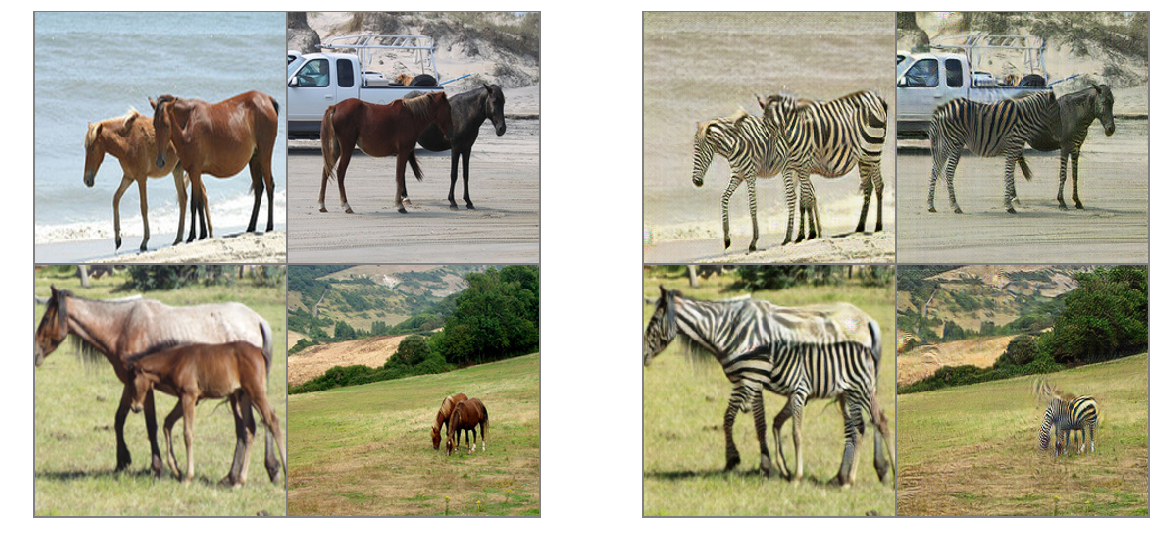

In [198]:
plt.figure(figsize=(20, 40))

plt.subplot(1, 2, 1)
imshow(make_grid(batch['A'], nrow=2))
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(make_grid(fake_B.data, nrow=2))
plt.axis('off')

### シマウマを馬に変換

In [42]:
# シマウマを馬に変換
batch = iter(test_loader).next()
fake_A = model.netG_B(batch['B'])
print(fake_A.shape)

torch.Size([4, 3, 256, 256])


In [ ]:
plt.figure(figsize=(20, 40))

plt.subplot(1, 2, 1)
imshow(make_grid(batch['B'], nrow=2))
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(make_grid(fake_A.data, nrow=2))
plt.axis('off')

## AとBを入れ替えてシマウマを馬に変換するモデルを学習した場合

- 以下のように書き換えるだけでOK
- ただ、DataLoaderは今までどおりAが馬でBがシマウマなので注意

```
    def set_input(self, input):
        input_A = input['B']
        input_B = input['A']
        if cuda:
            input_A = input_A.cuda()
            input_B = input_B.cuda()
        self.input_A = input_A
        self.input_B = input_B
        self.image_paths = input['path_B']
```

In [207]:
model = CycleGAN()
model.log_dir = 'logs_cyclegan_zebra2horse'
model.load('epoch30')

In [203]:
# batch = iter(test_loader).next()

In [208]:
# シマウマを馬に変換
fake_A = model.netG_A(batch['B'])
print(fake_A.shape)

torch.Size([4, 3, 256, 256])


In [ ]:
plt.figure(figsize=(20, 40))

plt.subplot(1, 2, 1)
imshow(make_grid(batch['B'], nrow=2))
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(make_grid(fake_A.data, nrow=2))
plt.axis('off')

## 馬やシマウマ以外の画像を入れるとどうなるか？

In [66]:
def convert2zebra(filename):
    img = Image.open(filename).convert('RGB')

    img_tensor = test_dataset.transform(img)
    img_tensor.unsqueeze_(0)

    fake_B = model.netG_A(Variable(img_tensor))

    plt.figure(figsize=(10, 20))

    plt.subplot(1, 2, 1)
    imshow(make_grid(img_tensor, nrow=2))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    imshow(make_grid(fake_B.data, nrow=2))
    plt.axis('off')

In [ ]:
convert2zebra('data/cat.jpg')

In [ ]:
convert2zebra('data/dog1.jpg')

In [ ]:
convert2zebra('data/dog2.jpg')

In [ ]:
convert2zebra('data/dog3.jpg')

In [ ]:
convert2zebra('data/bear.jpg')

In [ ]:
convert2zebra('data/horse1.jpg')

In [ ]:
convert2zebra('data/horse2.jpg')

In [ ]:
convert2zebra('data/white_horse.jpg')